<a href="https://colab.research.google.com/github/jumafernandez/UNLP/blob/master/TFI/LSA_LDA_TFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Cargo las librerías



In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary


### Levanto los datos

In [ ]:
# Descargo el archivo con las consultas que está en Github
!wget https://raw.githubusercontent.com/jumafernandez/UNLP/master/TFI/data/Correos_Seleccionados_y_Etiquetados.csv

# Leo el archivo en un dataframe
import pandas as pd

df = pd.read_csv('Correos_Seleccionados_y_Etiquetados.csv', delimiter="|")
df.info()

# Vemos la cantidad de Instancias por clase
df.Clase.value_counts()

# Transformamos todas las Clases minoritarias (Puedo ir variando la cantidad de clases que derivo a la Clase "Otras Consultas")
cantidad_clases=3
clases = df.Clase.value_counts()
clases_minoritarias = clases.iloc[cantidad_clases:].keys().to_list()
df.Clase[df['Clase'].isin(clases_minoritarias)] = "Otras Consultas"

df.Clase.value_counts()

--2020-12-07 22:48:00--  https://raw.githubusercontent.com/jumafernandez/UNLP/master/TFI/data/Correos_Seleccionados_y_Etiquetados.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448336 (438K) [text/plain]
Saving to: ‘Correos_Seleccionados_y_Etiquetados.csv.1’

Correos_Seleccionad 100%[===================>] 437.83K  --.-KB/s    in 0.02s   

2020-12-07 22:48:00 (24.1 MB/s) - ‘Correos_Seleccionados_y_Etiquetados.csv.1’ saved [448336/448336]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              1000 non-null   object
 1   Hora               1000 non-null   object
 2   Apellido y Nombre  1000 non

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Otras Consultas             399
Boleto Universitario        240
Ingreso a la Universidad    232
Requisitos de Ingreso       129
Name: Clase, dtype: int64

In [ ]:
# Miro las primeras dos consultas
df.head(2)

,Fecha,Hora,Apellido y Nombre,Legajo,Documento,Carrera,Teléfono,E-mail,Consulta,Respuesta,Clase
0,08-05-2019,10:49:26,florencia roland,169336,33829069,licenciatura en enfermeria(52),1121550750,rolandflorencia@gmail.com,"hola quiero anotarme a las materias ,para el s...",te falta presentar alguna de las vacunas sal...,Otras Consultas
1,08-08-2017,12:29:59,lourdes vanesa gómez,150786,33220121,licenciatura en enfermeria(52),1131066251,vane_male@outlook.com,hola buenos días! quería saber cuando voy a po...,lo que falta es que la coordinación autorice l...,Otras Consultas


In [ ]:
# Chequeo dimensionalidad
df.shape

NameError: ignored

In [ ]:
# Verifico las columnas del df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              606 non-null    object
 1   Hora               606 non-null    object
 2   Apellido y Nombre  606 non-null    object
 3   Legajo             606 non-null    object
 4   Documento          606 non-null    int64 
 5   Carrera            606 non-null    object
 6   Teléfono           606 non-null    object
 7   E-mail             606 non-null    object
 8   Consulta           606 non-null    object
 9   Respuesta          606 non-null    object
 10  Clase              606 non-null    object
dtypes: int64(1), object(10)
memory usage: 56.8+ KB


### Realizo el preprocesamiento de los datos

In [ ]:
# Defino una lista negra de palabras adicionales a las stop_words para borrar
black_list = ['más', 'mas', 'unir', 'paises', 'pais', 'espa', 'no', 'os', 'a', 'compa', 'acompa', 'off', 'and', 'grecia', 'the','it', 'to',
              'd',  'et',  'dame',  'il',  'dans', 'that',  'as',   'for',  'it',  'elections',  'would',  'this',  'with', 'york', 'obama', 'chavez', 'gadafi']

In [ ]:
# Creo una función que limpia el texto en español, borrando caracteres no alfanuméricos, removiendo duplicados, dígitos, etc, etc
def cleaner(word):
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
  word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
  word = re.sub(r'ee.uu', 'eeuu', word)
  word = re.sub(r'\#\.', '', word)
  word = re.sub(r'\n', '', word)
  word = re.sub(r',', '', word)
  word = re.sub(r'\-', ' ', word)
  word = re.sub(r'\.{3}', ' ', word)
  word = re.sub(r'a{2,}', 'a', word)
  word = re.sub(r'é{2,}', 'é', word)
  word = re.sub(r'i{2,}', 'i', word)
  word = re.sub(r'ja{2,}', 'ja', word) 
  word = re.sub(r'á', 'a', word)
  word = re.sub(r'é', 'e', word)
  word = re.sub(r'í', 'i', word)
  word = re.sub(r'ó', 'o', word)
  word = re.sub(r'ú', 'u', word)  
  word = re.sub('[^a-zA-Z]', ' ', word)
  list_word_clean = []
  for w1 in word.split(" "):
    if  w1.lower() not in stopwords:
      list_word_clean.append(w1.lower())

  bigram_list = bigram[list_word_clean]
  out_text = lemmatization(" ".join(bigram_list))
  return out_text

Se crea la función para seleccionar **solo sustantivos** para nuestros datos, de esta manera estamos eliminando adverbio, adjetivos, verbos, etc. Esto está hecho con spacy

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

Transformamos el dataframe a una lista como solicita gensim

In [ ]:
len(df.Consulta.to_list())

606

Luego buscamos bigrama en nuestros datos, es decir, un par de palabras que juntas tienen más significado para nuestro modelo.

In [ ]:
%%time
bigram = gensim.models.Phrases(df.Consulta.to_list()) 

CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 149 ms


Verificamos el output

In [ ]:
bigram[df.Consulta.to_list()[0].split()]

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['hola',
 'quiero',
 'anotarme',
 'a',
 'las',
 'materias',
 ',para',
 'el',
 'segundo',
 'cuatri',
 ',pero',
 'no',
 'puedo',
 ',dice',
 'que',
 'no',
 'estoy',
 'en',
 'condiciones,me',
 'podrian',
 'decir',
 'que',
 'tengo',
 'que',
 'hacer,muchas',
 'gracias']

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

additional_stopwords=set(black_list)

stopwords = stop.union(additional_stopwords)

Usamos spacy para lematizar las palabras

In [ ]:
!python -m spacy download es_core_news_md

     |████████████████████████████████| 78.4MB 1.2MB/s 
  Created wheel for es-core-news-md: filename=es_core_news_md-2.2.5-cp36-none-any.whl size=79649483 sha256=8c15adcdc0f02baf7bba3cfca584eb50e8b4baf27f38929047c60838c30f9385
  Stored in directory: /tmp/pip-ephem-wheel-cache-uwt3ad95/wheels/b7/bb/a3/29ab5cf80c2c0a8fa0f2af8402fdace3f159e8265f0fdcbcdb
Successfully built es-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [ ]:
import spacy
import spacy.cli
spacy.cli.download("es_core_news_md")
import es_core_news_md
nlp = es_core_news_md.load()

#nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/es_core_news_md/es_core_news_md-2.1.0')

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


Probamos la función para la limpieza de texto

In [ ]:
df.Consulta[0]

'hola quiero anotarme a las materias ,para el segundo cuatri ,pero no puedo ,dice que no estoy en condiciones,me podrian decir que tengo que hacer,muchas gracias  '

In [ ]:
cleaner(df.Consulta[0])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['materias', 'cuatri', 'hacermuchas', 'gracias']

##### Let's clean all the text

In [ ]:
df['Consulta_bp'] = df['Consulta']

In [ ]:
%%time
df['Consulta'] = df['Consulta'].apply(cleaner)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 6.04 s, sys: 5.05 ms, total: 6.04 s
Wall time: 6.04 s


Ahora necesitamos construir el **corpus** y el **diccionario** que gensim necesita para funcionar, para hacer eso necesitamos pasar la lista a una lista de tokens:

In [ ]:
dictionary = Dictionary(df['Consulta'].to_list())
dictionary.compactify()

# Filtro extremos
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df['Consulta'].to_list()]

corpus

[[(0, 1), (1, 1)],
 [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(0, 1), (4, 1), (7, 1), (8, 1), (9, 1)],
 [(0, 1), (10, 1)],
 [(11, 1), (12, 3), (13, 1)],
 [(0, 2), (4, 2), (14, 1)],
 [(15, 1)],
 [(11, 2), (16, 1), (17, 1), (18, 1)],
 [(0, 1), (19, 1), (20, 1), (21, 1)],
 [(0, 1),
  (1, 1),
  (12, 1),
  (13, 1),
  (15, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1)],
 [(0, 1), (11, 1), (22, 1), (26, 1)],
 [(0, 1), (17, 1), (27, 1), (28, 1), (29, 1), (30, 1)],
 [(8, 1), (27, 1)],
 [(0, 1), (31, 1), (32, 1), (33, 1)],
 [(34, 1)],
 [(0, 1), (27, 1), (35, 1), (36, 1)],
 [(17, 1)],
 [(9, 1), (37, 1)],
 [(11, 1), (12, 1), (38, 1), (39, 1)],
 [(0, 1), (30, 1), (40, 1), (41, 1), (42, 1), (43, 3)],
 [(44, 1)],
 [(1, 1), (4, 1), (45, 1), (46, 1)],
 [(0, 1), (4, 1), (25, 1), (27, 1), (28, 1), (47, 1), (48, 1)],
 [(45, 1), (49, 1)],
 [(0, 1), (28, 1), (48, 1), (50, 2), (51, 1)],
 [(0, 1), (20, 1), (25, 1), (30, 1)],
 [(0, 1), (11, 1), (17, 1), (25, 1)],
 [(17, 1), (28, 1), (52, 1)],
 [(0, 

# Now let's do the modeling part

We are comparing 3 topic modeling algorithm Latent Dirichlet Allocation (LDA), Latent
semantic analysis (LSA), Hierarchical Dirichlet Process
(HDP),in order to evaluate topic models we will be using **topic coherence**, which is a measure of how
interpretable topics are for human beings.

In [ ]:
def display_topics(model, model_type="lda"):
  for topic_idx, topic in enumerate(model.print_topics()):
    print ("Topic %d:" % (topic_idx))
    if model_type== "lsi":
      print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
    else:
      print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")
    



In [ ]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

##LSI MODEL

In [ ]:
lsimodel = LsiModel(corpus=corpus, num_topics=11, id2word=dictionary)

In [ ]:
display_topics(lsimodel)  # Showing the topics

Topic 0:
gracias boleto beneficio tardes materias clave respuesta dia carrera tarjeta 

Topic 1:
beneficio boleto gracias clave materias carrera tarjeta porcentaje sistema certificado 

Topic 2:
clave materias beneficio porcentaje carrera certificado gracias saludos correo perfil 

Topic 3:
boleto beneficio materias tardes porcentaje carrera certificado gracias tarjeta credenciales 

Topic 4:
materias clave boleto gracias porcentaje tardes certificado titulo solicitud respuesta 

Topic 5:
carrera gracias dia sistema tardes requisitos respuesta perfil noches contador 

Topic 6:
tardes gracias titulo solicitud saludos sistema problema requisitos beneficio estudiante 

Topic 7:
sistema requisitos tardes carrera estudiante saludos problema respuesta perfil clave 

Topic 8:
titulo solicitud tardes respuesta dia tarjeta sistema mensaje materias requisitos 

Topic 9:
dia tarjeta solicitud titulo respuesta beneficio carrera nombre quot consulta 

Topic 10:
tarjeta respuesta dia titulo mes favo

It seen that with 10 topics there is some themes with keywords related to: trump, venezuela, police, electiones, terrorism; still is a little difficult to gt some insight, because of this we are trying to select the best number of topics by iterate over a range of values and looking the coherence 

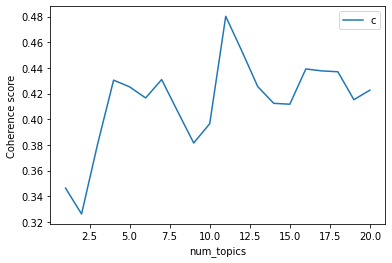

CPU times: user 11.5 s, sys: 2.14 s, total: 13.7 s
Wall time: 12.4 s


In [ ]:
%%time
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df['Consulta'].to_list(), limit=21, model= "lsi")

According to the coherence the best number of topics are between 3-7, however you must select the topics using both the coherence and visual inspection.


In [ ]:
display_topics(lmlist_lsi[2])

Topic 0:
gracias boleto beneficio tardes materias clave respuesta dia carrera tarjeta 

Topic 1:
beneficio boleto gracias clave materias carrera tarjeta porcentaje sistema certificado 

Topic 2:
clave materias beneficio porcentaje carrera certificado gracias saludos correo perfil 



Now, Let's try another model

## Latent Dirichlet Allocation Model

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary)

In [ ]:

display_topics(ldamodel)

Topic 0:
gracias materias beneficio dia semanas recarga respuestas mes clave carrera 

Topic 1:
clave gracias materias tardes solicitud porcentaje beneficio boleto perfil mente 

Topic 2:
gracias boleto clave tardes dia materias beneficio saludos titulo cargas 

Topic 3:
gracias clave tardes materias beneficio boleto datos respuesta carrera dia 

Topic 4:
gracias materias tarjeta beneficio cuatrimestre saludos carrera universidad consulta boleto 

Topic 5:
gracias legajo clave tiempo favor noches problemas respuesta carrera contador 

Topic 6:
beneficio boleto sistema requisitos gracias carrera tardes alumno solicitud servicios 

Topic 7:
gracias beneficio boleto tardes plan estudiante dia consulta tarjeta carga 

Topic 8:
gracias beneficio boleto problema clave sistema consulta tarjeta dia tardes 

Topic 9:
materias gracias boleto beneficio porcentaje carrera respuesta tardes perfil requisitos 

Topic 10:
requisitos problema estudiante clave sistema casilla gracias perfil materias mai

Find out the optimal number of topics for the LDA model based on the coherence metric:

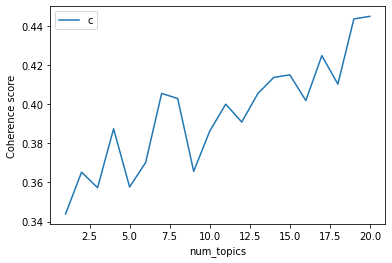

CPU times: user 18.5 s, sys: 907 ms, total: 19.4 s
Wall time: 19.9 s


In [ ]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df['Consulta'].to_list(), limit=21, model= "lda")

For this model it seems that  9 or 18, again we must to check the keywords too.

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [ ]:

ldamodel = lmlist[11]
lsimodel = lmlist_lsi[2]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [ ]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df['text'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df['text'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=df['text'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

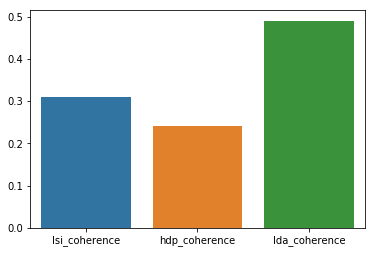

In [ ]:
import seaborn as sns

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence','hdp_coherence', 'lda_coherence']
sns.barplot(x, coherences)


We can see that the **LdaModel** model **with 8 topics** has the higher value of
coherence

Examine the keyword to get the topics of the best model

In [ ]:

display_topics(ldamodel)

Topic 0:
derechos humanos muerte guerra tribunal juez caso libertad personas juicio 

Topic 1:
estudio tierra universidad mundo agua investigadores cambio expertos corea sistema 

Topic 2:
policia hombre casa mujer muerte familia hospital autoridades caso despues 

Topic 3:
presidente gobierno ministro justicia mubarak pueblo presos venezuela jefe caso 

Topic 4:
mujeres mundo mujer papa vida iglesia matrimonio caso hombres casos 

Topic 5:
personas metros rescate zona autoridades isla mar kilometros agua horas 

Topic 6:
partido presidente elecciones votos gobierno candidato comicios partidos domingo ministro 

Topic 7:
personas seguridad fuerzas ciudad ataque policia fuentes grupo ataques protestas 

Topic 8:
millones euros gobierno dolares medidas crisis parte empresas trabajo sector 

Topic 9:
personas terremoto ayuda ciudad seismo zonas zona millones agua muertos 

Topic 10:
gobierno presidente ministro consejo acuerdo seguridad parte paz union asuntos 

Topic 11:
aeropuerto avion

It looks like the topics are:
* Topic 0: is about trials (justice)
* Topic 1: is like nature studies
* Topic 2: is about violence (against women maybe?)
* Topic 3: protest and disturb (like venezuelan case)
* Topic 4: is about life and family
* Topic 5: sea disasters
* Topic 6: elections
* Topic 7: is about terrorism
* Topic 8: is about economic crisis
* Topic 9: is like seism studies
* Topic 10: is about peacy treaty
* Topic 11: airport and security


Let´s check the keyword when we selecting another number of topics (14)

In [ ]:
ldamodel_16 =lmlist[16]


In [ ]:
display_topics(ldamodel_16)

Topic 0:
presidente casa washington congreso barack informacion documentos inteligencia seguridad programa 

Topic 1:
gobierno ministro partido parlamento union acuerdo crisis presidente consejo parte 

Topic 2:
millones euros dolares gobierno ley dinero empresas medidas parte proyecto 

Topic 3:
personas ciudad centro policia seguridad plaza lugar autoridades atentado edificio 

Topic 4:
partido elecciones votos candidato presidente comicios domingo victoria resultados vuelta 

Topic 5:
fuerzas seguridad ataque grupo soldados ataques ciudad guerra personas gobierno 

Topic 6:
mujer familia vida padre madre hijo hijos casa hospital mundo 

Topic 7:
policia muerte personas hombre autoridades caso mujer asesinato agentes juez 

Topic 8:
estudio millones mundo informe personas agua datos salud nivel parte 

Topic 9:
mujeres papa iglesia casos caso abusos personas parte derechos matrimonio 

Topic 10:
presidente gobierno seguridad paz ministro consejo acuerdo parte asuntos naciones 

Topic

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [ ]:
def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df['text'].to_list())



In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.5252,"partido, presidente, elecciones, votos, gobier...","[presidente, trump, quejo, jueves, seguidores,..."
1,1,10.0,0.6767,"gobierno, presidente, ministro, consejo, acuer...","[gobernador, hector, conversaciones, gobierno,..."
2,2,9.0,0.4595,"personas, terremoto, ayuda, ciudad, seismo, zo...","[autoridades, congo, jueves, muerte, centenar,..."
3,3,8.0,0.3184,"millones, euros, gobierno, dolares, medidas, c...","[ministro, shinzo, abe, viernes, disculpas, fa..."
4,4,5.0,0.3357,"personas, metros, rescate, zona, autoridades, ...","[guardia, submarino, kilos, aguas, abordaje, s..."
5,5,2.0,0.5224,"policia, hombre, casa, mujer, muerte, familia,...","[condado, ohio, sentencia, profesora, contacto..."
6,6,10.0,0.6356,"gobierno, presidente, ministro, consejo, acuer...","[gobierno, kyriakos, viernes, presidente, parl..."
7,7,3.0,0.4092,"presidente, gobierno, ministro, justicia, muba...","[barco, watch, carola, inmigrantes, viernes, q..."
8,8,5.0,0.3907,"personas, metros, rescate, zona, autoridades, ...","[policia, viernes, tripulantes, grace, capitan..."
9,9,6.0,0.5685,"partido, presidente, elecciones, votos, gobier...","[presidente, trump, viernes, gobierno, domingo..."


We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [ ]:
label_dicc = {0:'trials', 1:'nature', 2:'violence', 3: 'protest', 4:'life_family', 5:'sea_disasters', 6:'elections', 
              7:'terrorism', 8:'economic_crisis', 9: 'seism', 10:'peacy_treaty', 11:'airport_security'}

In [ ]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')


In [ ]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,elections,0.5252,"partido, presidente, elecciones, votos, gobier...","[presidente, trump, quejo, jueves, seguidores,..."
1,1,peacy_treaty,0.6767,"gobierno, presidente, ministro, consejo, acuer...","[gobernador, hector, conversaciones, gobierno,..."
2,2,seism,0.4595,"personas, terremoto, ayuda, ciudad, seismo, zo...","[autoridades, congo, jueves, muerte, centenar,..."
3,3,economic_crisis,0.3184,"millones, euros, gobierno, dolares, medidas, c...","[ministro, shinzo, abe, viernes, disculpas, fa..."
4,4,sea_disasters,0.3357,"personas, metros, rescate, zona, autoridades, ...","[guardia, submarino, kilos, aguas, abordaje, s..."
5,5,violence,0.5224,"policia, hombre, casa, mujer, muerte, familia,...","[condado, ohio, sentencia, profesora, contacto..."
6,6,peacy_treaty,0.6356,"gobierno, presidente, ministro, consejo, acuer...","[gobierno, kyriakos, viernes, presidente, parl..."
7,7,protest,0.4092,"presidente, gobierno, ministro, justicia, muba...","[barco, watch, carola, inmigrantes, viernes, q..."
8,8,sea_disasters,0.3907,"personas, metros, rescate, zona, autoridades, ...","[policia, viernes, tripulantes, grace, capitan..."
9,9,elections,0.5685,"partido, presidente, elecciones, votos, gobier...","[presidente, trump, viernes, gobierno, domingo..."


In [ ]:
df['labels'] = df_dominant_topic['Dominant_Topic']


Let's examine some text and its topics

In [ ]:
df[['text2', 'labels']].head(10)

,text2,labels
0,"El presidente estadounidense, Donald Trump, s...",elections
1,El gobernador del estado venezolano de Mirand...,peacy_treaty
2,Las autoridades de la República Democrática d...,seism
3,"El primer ministro nipón, Shinzo Abe, pidió e...",economic_crisis
4,La Guardia Costera de EE UU ha interceptado u...,sea_disasters
5,"Una jueza del condado de Hamilton (Ohio, EE U...",violence
6,El nuevo Gobierno griego del conservador Kyri...,peacy_treaty
7,La capitana del barco humanitario Sea Watch 3...,protest
8,La Policía de Gibraltar ha detenido este vier...,sea_disasters
9,"El presidente de Estados Unidos, Donald Trump...",elections


In [ ]:
df[ df['labels'] == 'family'].head().text2

5      Una jueza del condado de Hamilton (Ohio, EE U...
7      La capitana del barco humanitario Sea Watch 3...
10     Un bebé de un año ha muerto en la localidad f...
12     Una mujer de Nueva York denunció este miércol...
14     El fiscal general venezolano, Tarek Saab, inf...
Name: text2, dtype: object

### let's see the distribution of topics


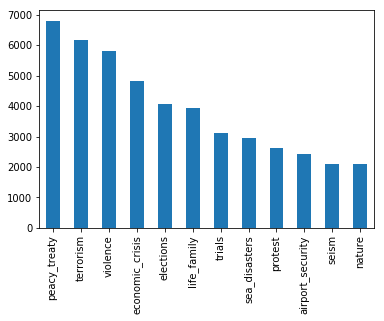

In [ ]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 11.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=2a06ca43d78c9313544ee206c33ccd010fb9abae4821762434ad95a07c9fb866
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [ ]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

NameError: ignored

https://www.tutorialspoint.com/gensim/gensim_creating_lsi_and_hdp_topic_model.htm

https://github.com/ArmandDS/topic_modeling/blob/master/topic_modeling_spanish.ipynb